In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import regularizers
import utils

# Estilo de plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]

TensorFlow Version: 2.19.0


In [4]:
file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shannanl/sp500-dataset",
  file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

TICKER = "AAPL"
df_raw = utils.load_comp_data(df, TICKER)

# Feature Engineering
WINDOW_SIZE = 20
df_fe = utils.compute_features(df_raw, w=WINDOW_SIZE, cut=False)

/tmp/ipython-input-1978235452.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'sp500-dataset' dataset.


/content/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)


In [6]:
df_fe.head()

,timestep,AAPL_high,AAPL_low,AAPL_open,AAPL_close,AAPL_volume,log_return,true_range,rsd_20,ntv_20,...,bollinger_mid,bollinger_upper,bollinger_lower,bollinger_width,bollinger_percent_b,rsi_w,obv,volume_z,candle_body,candle_range_ratio
0,21,-0.753801,-0.437338,-0.511836,-0.543120,-0.429525,-0.162207,-0.923054,-1.275773,-0.405100,...,0.416632,0.400473,0.303671,-0.063408,-0.679172,0.707107,0.189257,-0.337170,-0.166280,-0.478390
1,22,-0.385802,0.048626,-0.551463,0.108801,-0.355686,0.937758,-0.760345,-1.057790,-0.282248,...,0.569193,0.374671,0.635541,-0.304447,-0.003303,0.846134,0.557347,-0.209340,0.937028,1.575921
2,23,0.461849,0.476481,0.066597,0.703576,-0.449911,1.113259,-0.270381,-1.679266,-0.365208,...,0.960306,0.563160,1.146855,-0.653697,0.569610,1.362499,0.834659,-0.242662,1.152047,1.252007
3,24,0.997831,0.735544,0.663865,1.413442,-0.401475,1.454395,0.264062,-1.474384,-0.307290,...,1.298697,1.122298,1.195224,-0.143196,1.241598,1.092520,1.097092,-0.228390,1.555897,1.378007
4,25,1.151933,1.344689,1.490409,1.361512,-0.478139,0.200753,-0.889748,-1.546516,-0.394083,...,1.578165,1.528562,1.402461,0.135958,1.071306,1.066742,1.294222,-0.310425,0.204213,0.297669


In [9]:
def create_sequences(data_X, data_y, data_prices, lookback=10):
    """
    Secuencias temporales
    Args:
        data_X: Features normalizados.
        data_y: Target (log_next_day_max_return).
        data_prices: Precio de cierre original (para reconstrucción).
        lookback: Cuántos pasos hacia atrás mira la LSTM.
    Returns:
        X, y, precios_base
    """
    X, y, base_prices = [], [], []

    for i in range(len(data_X) - lookback):
        X.append(data_X[i : i + lookback])
        y.append(data_y[i + lookback])
        base_prices.append(data_prices[i + lookback])
    return np.array(X), np.array(y), np.array(base_prices)

# Definir columnas de features
feature_cols = [c for c in df_fe.columns if c not in ['timestep', 'log_next_day_max_return']]
data_X_raw = df_fe[feature_cols].values
data_y_raw = df_fe['log_next_day_max_return'].values
data_close_raw = df_fe[f'{TICKER}_close'].values

LOOKBACK = 10

X, y, close_prices = create_sequences(data_X_raw, data_y_raw, data_close_raw, lookback=LOOKBACK)

print(f"Forma de X (Samples, Timesteps, Features): {X.shape}")
print(f"Forma de y: {y.shape}")

Forma de X (Samples, Timesteps, Features): (5451, 10, 29)
Forma de y: (5451,)


In [10]:
# 80% entrenamiento, 20% prueba
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
prices_train, prices_test = close_prices[:split_idx], close_prices[split_idx:]

print(f"Entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Prueba: X={X_test.shape}, y={y_test.shape}")

Entrenamiento: X=(4360, 10, 29), y=(4360,)
Prueba: X=(1091, 10, 29), y=(1091,)


In [29]:
model = Sequential()

# Return sequences=True para apilar otra LSTM
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32,
               return_sequences=True,
               kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(LSTM(units=16,
               return_sequences=False,
               kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(25, activation='relu'))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 32)         │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,523 (45.01 KB)

 Trainable params: 11,523 (45.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0982 - val_loss: 0.0526
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0472 - val_loss: 0.0277
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0254 - val_loss: 0.0155
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0148 - val_loss: 0.0094
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 9.5194e-04
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0018 - val_loss: 6.8977e-04
Epoch 12/50
123/123 ━━━━━━━━━━━━━

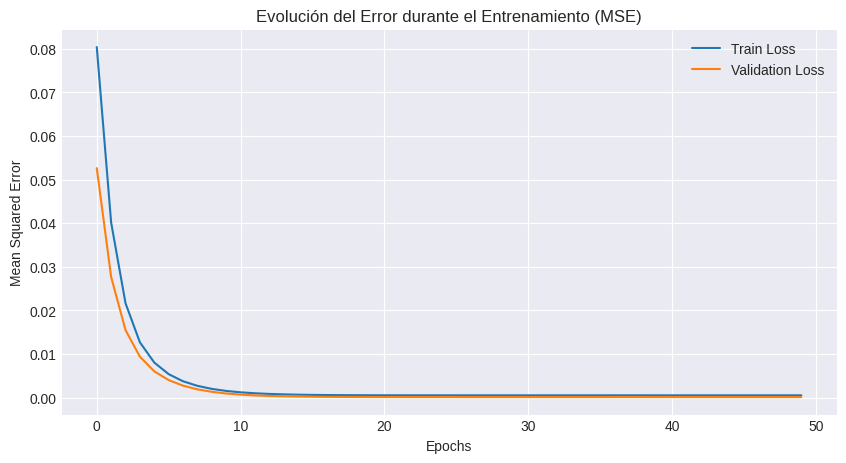

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
--- Métricas en Escala Logarítmica (Return) ---
MSE: 0.000237
MAE: 0.010168
R2: -0.0087


In [30]:
# Plot de la pérdida (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución del Error durante el Entrenamiento (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

y_pred = model.predict(X_test)

# Métricas en escala logarítmica
print("--- Métricas en Escala Logarítmica (Return) ---")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

In [31]:
y_pred_flat = y_pred.flatten()

real_high_prices = prices_test * np.exp(y_test)
# Calcular High predicho
pred_high_prices = prices_test * np.exp(y_pred_flat)
df_results = pd.DataFrame({
    'Real_Price_High': real_high_prices,
    'Pred_Price_High': pred_high_prices,
    'Error_Abs': np.abs(real_high_prices - pred_high_prices)
})

print("--- Primeras 5 Predicciones de Precios (USD) ---")
print(df_results.head())

print("\n--- Métricas en Precios Reales (USD) ---")
print(f"MAE (Precio): ${mean_absolute_error(real_high_prices, pred_high_prices):.2f}")
print(f"RMSE (Precio): ${np.sqrt(mean_squared_error(real_high_prices, pred_high_prices)):.2f}")

--- Primeras 5 Predicciones de Precios (USD) ---
   Real_Price_High  Pred_Price_High  Error_Abs
0        -2.233231        -2.186607   0.046624
1        -1.092474        -1.099293   0.006819
2        -1.258844        -1.262063   0.003219
3        -0.963819        -0.967840   0.004021
4        -0.926155        -0.925586   0.000569

--- Métricas en Precios Reales (USD) ---
MAE (Precio): $0.01
RMSE (Precio): $0.02


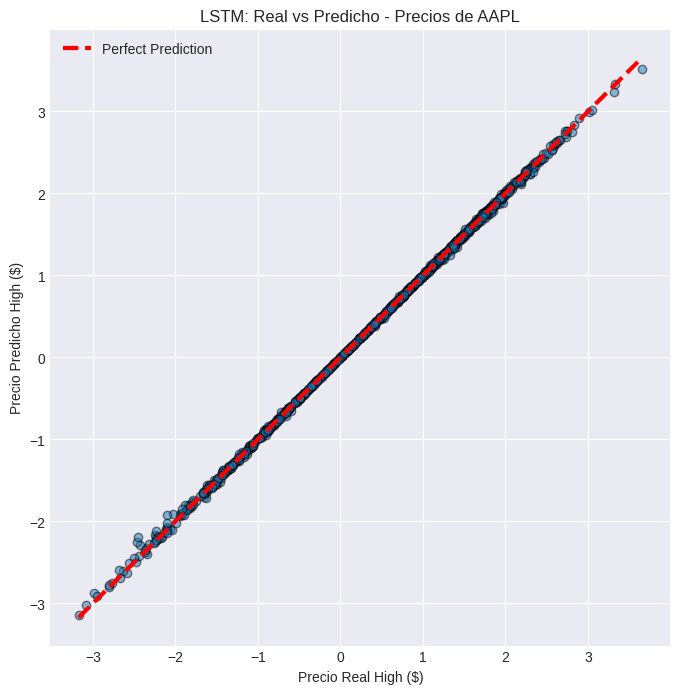

In [32]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(real_high_prices, pred_high_prices, alpha=0.5, edgecolors='k')

min_val = min(real_high_prices.min(), pred_high_prices.min())
max_val = max(real_high_prices.max(), pred_high_prices.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction')

ax.set_xlabel('Precio Real High ($)')
ax.set_ylabel('Precio Predicho High ($)')
ax.set_title(f'LSTM: Real vs Predicho - Precios de {TICKER}')
plt.legend()
plt.show()

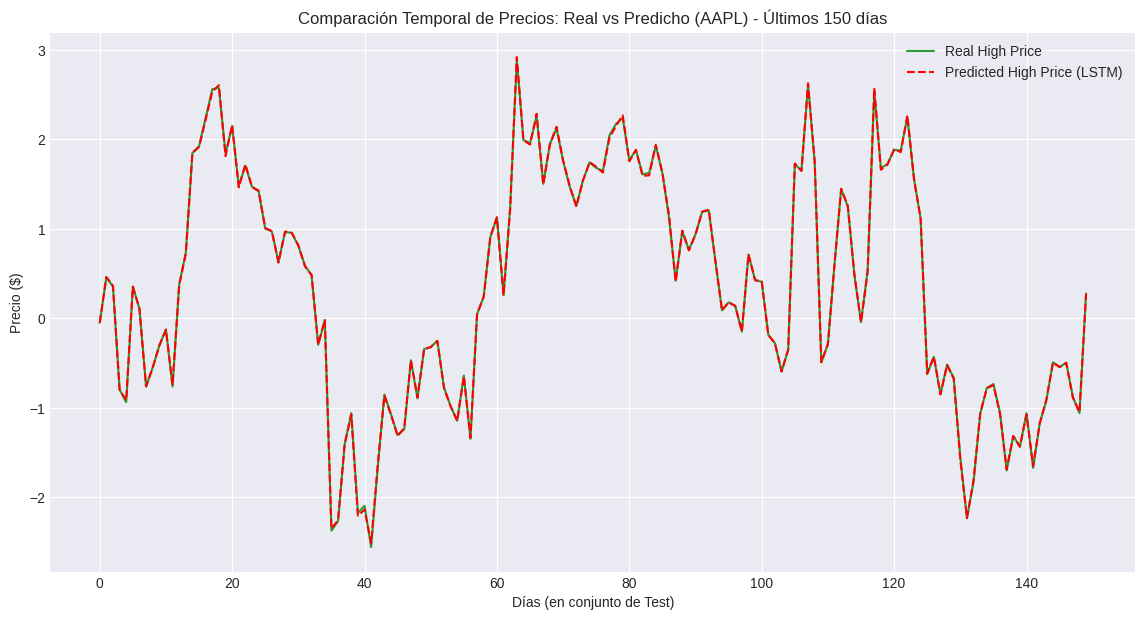

In [33]:
subset_n = 150

plt.figure(figsize=(14, 7))
plt.plot(df_results['Real_Price_High'].tail(subset_n).values, label='Real High Price', color='green', alpha=0.8)
plt.plot(df_results['Pred_Price_High'].tail(subset_n).values, label='Predicted High Price (LSTM)', color='red', linestyle='--')

plt.title(f'Comparación Temporal de Precios: Real vs Predicho ({TICKER}) - Últimos {subset_n} días')
plt.xlabel('Días (en conjunto de Test)')
plt.ylabel('Precio ($)')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import r2_score, mean_squared_error

train_preds = model.predict(X_train, verbose=0)
test_preds = model.predict(X_test, verbose=0)

r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)

print(f"R² Training: {r2_train:.4f}")
print(f"R² Testing:  {r2_test:.4f}")

# 3. Diagnóstico
gap = r2_train - r2_test
if gap > 0.2: # Umbral arbitrario pero útil
    print(f"ALERTA: Brecha grande ({gap:.4f}). Alto riesgo de Overfitting.")
elif r2_train > 0.90 and r2_test < 0.5:
    print("ALERTA: El modelo ha memorizado el ruido del entrenamiento.")
else:
    print("La brecha entre entrenamiento y prueba es razonable.")

R² Training: -0.0650
R² Testing:  -0.0087
La brecha entre entrenamiento y prueba es razonable.
